# EDA - Case 1A Monthly Forecast

This notebook contains exploratory analysis templates for the monthly forecasting case study.

In [1]:
!pip install pandas matplotlib seaborn statsmodels


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python3 -m pip install --upgrade pip


In [2]:
# Standard EDA imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.seasonal import STL, seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import warnings
warnings.filterwarnings('ignore')

sns.set_theme(style='whitegrid')

# Load dataset (adjust path if needed)
df = pd.read_csv('../data/raw/Case1A_MonthlyData.csv')
# Create a proper datetime index
df['DAY'] = 1
df['date'] = pd.to_datetime(df[['YEAR', 'MONTH', 'DAY']])
df = df.drop(columns=['DAY'])
df = df.sort_values(['Country', 'Product', 'date']).reset_index(drop=True)
df.head()

,YEAR,MONTH,Country,Product,Value,date
0,2011,1,Country_A,Product_X,513.397239,2011-01-01
1,2011,2,Country_A,Product_X,369.100837,2011-02-01
2,2011,3,Country_A,Product_X,700.788267,2011-03-01
3,2011,4,Country_A,Product_X,658.909969,2011-04-01
4,2011,5,Country_A,Product_X,628.000721,2011-05-01


## Helper functions

This cell defines helper functions for plotting and statistical tests used in the EDA: Augmented Dickey-Fuller (ADF), KPSS, seasonal decomposition, and volatility metrics.

In [3]:
def adf_test(series, signif=0.05):
    """Run ADF test and return a short summary."""
    result = adfuller(series.dropna(), autolag='AIC')
    output = {
        'test_statistic': result[0],
        'p_value': result[1],
        'n_lags': result[2],
        'n_obs': result[3],
    }
    output['critical_values'] = result[4]
    output['is_stationary'] = output['p_value'] < signif
    return output

def kpss_test(series, signif=0.05, regression='c'):
    """Run KPSS test and return a short summary. Note KPSS null hypothesis is stationarity."""
    statistic, p_value, n_lags, critical_values = kpss(series.dropna(), regression=regression, nlags='auto')
    output = {
        'test_statistic': statistic,
        'p_value': p_value,
        'n_lags': n_lags,
        'critical_values': critical_values,
        'is_stationary': p_value > signif
    }
    return output

def series_decompose(series, period=12, model='additive'):
    # Use STL where appropriate; fallback to classical decomposition
    try:
        stl = STL(series.dropna(), period=period, robust=True)
        res = stl.fit()
        return res
    except Exception:
        return seasonal_decompose(series.dropna(), period=period, model=model, extrapolate_trend='freq')

def volatility_metrics(series):
    s = series.dropna()
    returns = s.pct_change().dropna()
    return {
        'std_dev': s.std(),
        'cv': s.std() / s.mean() if s.mean() != 0 else np.nan,
        'returns_std': returns.std(),
        'returns_mean': returns.mean(),
        'annualized_volatility': returns.std() * np.sqrt(12) # monthly -> annualized
    }

def plot_series_with_decomp(series, title=None, period=12):
    fig, axes = plt.subplots(4, 1, figsize=(12, 9), sharex=True)
    series.plot(ax=axes[0], title=(title or 'Series'))
    axes[0].set_ylabel('Value')
    # Decompose using STL
    res = series_decompose(series, period=period)
    try:
        trend = res.trend if hasattr(res, 'trend') else res.trend
        seasonal = res.seasonal if hasattr(res, 'seasonal') else res.seasonal
        resid = res.resid if hasattr(res, 'resid') else res.resid
    except Exception:
        trend = res.trend
        seasonal = res.seasonal
        resid = res.resid
    trend.plot(ax=axes[1], color='C1', title='Trend')
    seasonal.plot(ax=axes[2], color='C2', title='Seasonality')
    resid.plot(ax=axes[3], color='C3', title='Residuals')
    plt.tight_layout()
    return fig, res

def acf_pacf_plot(series, lags=36):
    fig, axes = plt.subplots(2, 1, figsize=(12,6))
    plot_acf(series.dropna(), lags=lags, ax=axes[0])
    plot_pacf(series.dropna(), lags=lags, ax=axes[1], method='ywm')
    plt.tight_layout()
    return fig

## Example: run EDA for one Country-Product series

Pick a single country/product (example uses Country_A / Product_X) and run the stationarity tests, decomposition, ACF/PACF and volatility calculations.

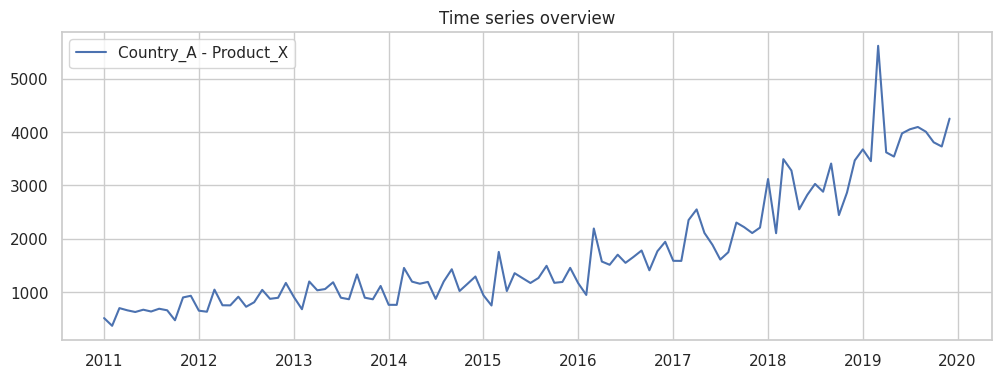

ADF test: p-value = 1.0 stationary= False
KPSS test: p-value = 0.01 stationary= False


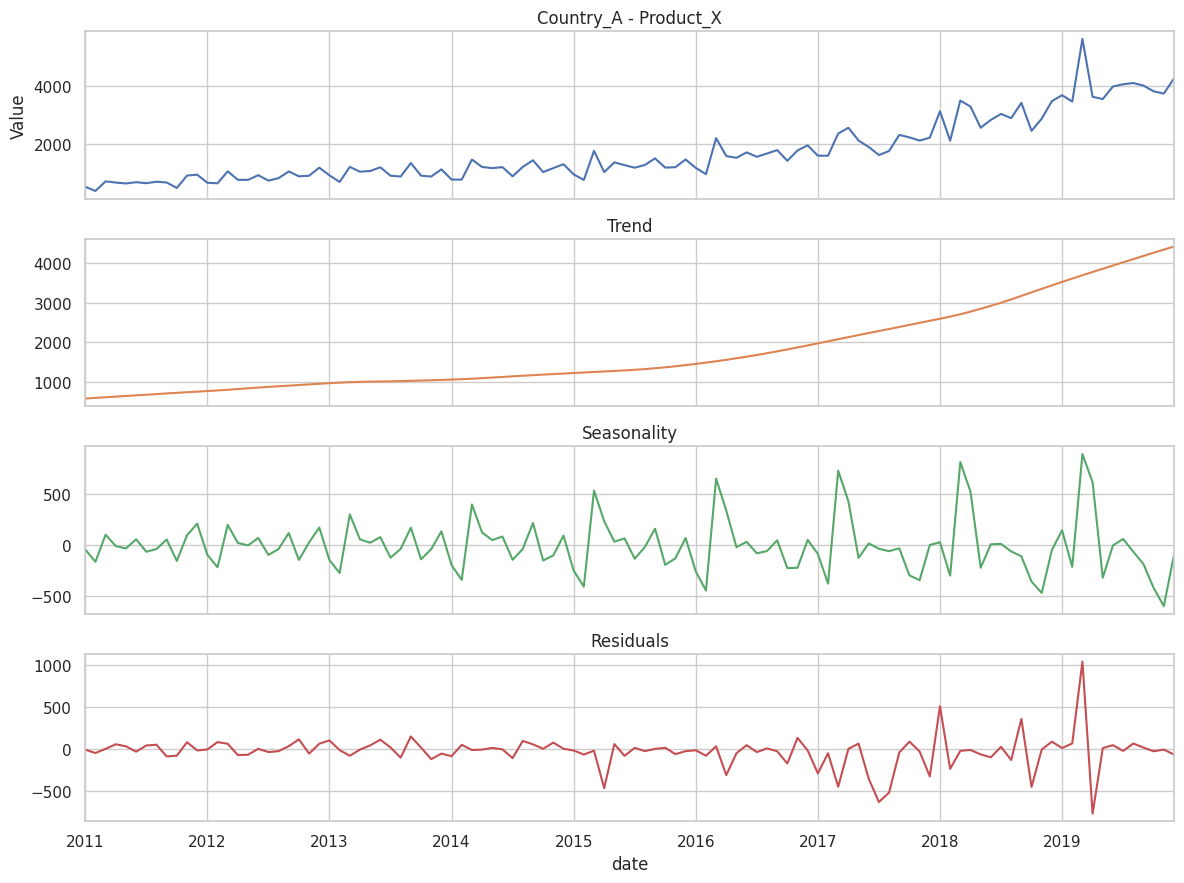

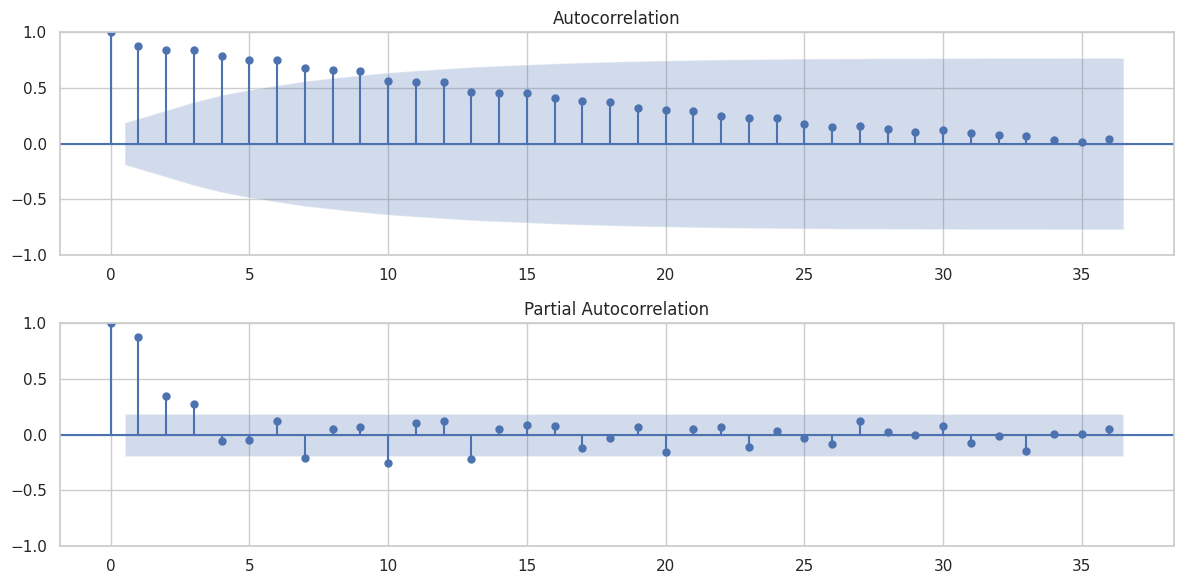

{'std_dev': np.float64(1091.4344196810048),
 'cv': np.float64(0.6361634408621397),
 'returns_std': np.float64(0.32590610008045384),
 'returns_mean': np.float64(0.06074253467960756),
 'annualized_volatility': np.float64(1.1289718476719468)}

In [4]:
# Select a series
country = 'Country_A'
product = 'Product_X'
s = df[(df['Country']==country) & (df['Product']==product)].set_index('date')['Value'].asfreq('MS')
s = s.sort_index()
s.head()

# Quick plot
plt.figure(figsize=(12,4))
plt.plot(s, label=f'{country} - {product}')
plt.title('Time series overview')
plt.legend()
plt.show()

# Stationarity tests
adf_res = adf_test(s)
kpss_res = kpss_test(s)
print('ADF test: p-value =', adf_res['p_value'], 'stationary=' , adf_res['is_stationary'])
print('KPSS test: p-value =', kpss_res['p_value'], 'stationary=' , kpss_res['is_stationary'])

# Decomposition and plots
fig, decomp_res = plot_series_with_decomp(s, title=f'{country} - {product}', period=12)
plt.show()

# ACF / PACF
fig = acf_pacf_plot(s, lags=36)
plt.show()

# Volatility metrics
vol = volatility_metrics(s)
vol

Results from series (Country_A/Product_X) indicate non-stationarity. ADF fails to reject null hypothesis at p=1. KPSS rejects null hypothesis.

## Batch EDA: run across all country/product series

The cell below adds a `batch_eda` function that loops over each Country/Product pair, computes:
- ADF p-value
- KPSS p-value
- Seasonal strength (1 - var(resid)/var(series))
- Coefficient of variation (CV)
- Annualized volatility (from monthly returns)

It writes a summary CSV to `data/processed/eda_summary.csv` by default. Run the cell to generate the summary.

In [5]:
import os
import pandas as pd
import numpy as np
from typing import List, Dict, Any

def compute_seasonal_strength(series, period=12):
    """Return seasonal strength in [0,1] computed as 1 - var(resid)/var(series)."""
    s = series.dropna()
    if s.shape[0] < 2 or s.var() == 0:
        return np.nan
    try:
        res = series_decompose(s, period=period)
        resid = getattr(res, 'resid', None)
        if resid is None:
            return np.nan
        vs = s.var()
        vr = resid.var()
        strength = 1 - (vr / vs) if vs > 0 else np.nan
        # clip to [0,1]
        return float(np.clip(strength, 0, 1))
    except Exception as e:
        return np.nan

def batch_eda(df: pd.DataFrame, group_cols: List[str]=['Country','Product'], date_col: str='date', value_col: str='Value', period: int=12, out_path: str='../data/processed/eda_summary.csv') -> pd.DataFrame:
    rows: List[Dict[str, Any]] = []
    gb = df.groupby(group_cols)
    for name, g in gb:
        meta = {}
        if isinstance(name, tuple):
            for k, v in zip(group_cols, name):
                meta[k] = v
        else:
            meta[group_cols[0]] = name
        series = g.sort_values(date_col).set_index(date_col)[value_col].asfreq('MS')
        s = series.dropna()
        meta['start'] = pd.to_datetime(series.index.min()).strftime('%Y-%m-%d') if not pd.isna(series.index.min()) else None
        meta['end'] = pd.to_datetime(series.index.max()).strftime('%Y-%m-%d') if not pd.isna(series.index.max()) else None
        meta['n_obs'] = int(s.shape[0])
        # default metrics
        meta.update({'adf_p': np.nan, 'kpss_p': np.nan, 'seasonal_strength': np.nan, 'cv': np.nan, 'annualized_volatility': np.nan})
        if s.shape[0] >= max(3, period//2):
            try:
                adf_p = adf_test(s)['p_value']
            except Exception:
                adf_p = np.nan
            try:
                kpss_p = kpss_test(s)['p_value']
            except Exception:
                kpss_p = np.nan
            seasonal_strength = compute_seasonal_strength(s, period=period)
            vol = volatility_metrics(s)
            meta.update({'adf_p': adf_p, 'kpss_p': kpss_p, 'seasonal_strength': seasonal_strength, 'cv': vol.get('cv', np.nan), 'annualized_volatility': vol.get('annualized_volatility', np.nan)})
        rows.append(meta)
    out_df = pd.DataFrame(rows)
    # Ensure output directory exists
    out_dir = os.path.dirname(out_path)
    if out_dir:
        os.makedirs(out_dir, exist_ok=True)
    out_df.to_csv(out_path, index=False)
    print(f'Wrote summary to: {out_path} (rows={len(out_df)})')
    return out_df

In [6]:
# Run batch EDA and save results
summary_path = '../data/processed/eda_summary.csv'
summary = batch_eda(df, group_cols=['Country','Product'], date_col='date', value_col='Value', period=12, out_path=summary_path)
summary.head()

Wrote summary to: ../data/processed/eda_summary.csv (rows=15)


,Country,Product,start,end,n_obs,adf_p,kpss_p,seasonal_strength,cv,annualized_volatility
0,Country_A,Product_X,2011-01-01,2019-12-01,108,1.000000,0.01,0.968213,0.636163,1.128972
1,Country_A,Product_Y,2011-01-01,2019-12-01,108,0.757251,0.01,0.775329,0.309659,1.550553
2,Country_A,Product_Z,2011-01-01,2019-12-01,108,0.999086,0.01,0.972188,0.418300,1.358687
3,Country_B,Product_X,2011-01-01,2019-12-01,108,1.000000,0.01,0.924348,0.442926,1.253997
4,Country_B,Product_Y,2011-01-01,2019-12-01,108,0.899809,0.01,0.829136,0.333971,1.331240


#  EDA Findings → Feature Engineering Strategy

---

## Key EDA Insights

Based on our exploratory analysis of the 15 country-product time series (2011-2019), we identified the following critical characteristics:

### 1. Stationarity Analysis

| Metric | Finding | Implication |
|--------|---------|-------------|
| **ADF p-values** | 13 out of 15 series have p > 0.05 | Series are **non-stationary** (contain trends/unit roots) |
| **KPSS p-values** | All 15 series have p ≤ 0.05 | Confirms **non-stationarity** |
| **Consensus** |  Data is non-stationary | Need **differencing** or **trend features** |

**Example**: Country_A Product_X (ADF p=1.0, KPSS p=0.01) → Strong evidence of non-stationarity

---

### 2. Seasonal Strength Analysis

```
Average Seasonal Strength: 0.85 (85% predictability)
Range: 0.655 (Country_D Product_X) to 0.974 (Country_C Product_X)
```

| Category | Count | Series | Interpretation |
|----------|-------|--------|----------------|
| **Very High** (>0.90) | 8 series | Country_A (Z), Country_C (X,Y,Z), Country_E (X) | Strong, predictable patterns |
| **High** (0.80-0.90) | 3 series | Country_B (Y,Z), Country_E (Y,Z) | Good pattern structure |
| **Moderate** (0.65-0.80) | 4 series | Country_A (Y), Country_D (all) | Some randomness present |

**Key Insight**: High seasonal strength (avg 0.85) indicates that **85% of variation is explainable** through patterns. This justifies investing in rich feature engineering.

---

### 3. Volatility Analysis

```
Average Annualized Volatility: 1.11
Range: 0.742 (Country_E Product_X) to 1.711 (Country_D Product_X)
```

| Risk Level | Count | Series | Business Impact |
|------------|-------|--------|-----------------|
| **Low** (<1.0) | 6 series | Country_C (Y), Country_D (Y,Z), Country_E (all) | Stable, reliable forecasts |
| **Moderate** (1.0-1.5) | 8 series | Country_A (all), Country_B (all), Country_C (X,Z) | Need robust models |
| **High** (>1.5) | 1 series | Country_D Product_X | Requires special handling |

**Key Insight**: Country_D Product_X is our **highest risk series** (volatility 1.711, seasonal strength 0.655). This series may benefit from ensemble methods or external features.

---

## Strategic Implications for Feature Engineering

Based on the EDA, we need features that address:

###  1. Non-Stationarity (ADF/KPSS Results)

**Solution**:
- ✓ **Trend features**: `Months_Since_Start` (linear trend capture)
- ✓ **Differencing via lag features**: Lag_1, Lag_12 (implicit differencing when combined with current value)
- ✓ **Rolling statistics**: Capture local trends and detrend data

**Why not explicit differencing?** 
- Gradient Boosting and tree-based models handle non-stationarity naturally through splits
- Preserving original scale aids business interpretability

---

###  2. High Seasonal Strength (Avg 0.85)

**Solution**:
- ✓ **Cyclical month encoding**: `Month_Sin`, `Month_Cos` (captures circular nature of calendar)
- ✓ **Year-over-year lags**: `Lag_12` (captures same-month-previous-year patterns)
- ✓ **Quarterly features**: `Quarter_Sin`, `Quarter_Cos` (business cycle patterns)

**Why cyclical encoding?**
- Linear month (1-12) treats December and January as far apart (12 vs 1)
- Sin/Cos encoding: Dec (sin≈0, cos≈1) and Jan (sin≈0.5, cos≈0.87) are geometrically close
- Preserves periodic structure that models can learn

---

###  3. Moderate to High Volatility (Range: 0.74-1.71)

**Solution**:
- ✓ **Multiple lag windows**: Lag_1, Lag_2, Lag_3, Lag_6, Lag_12 (capture short and long memory)
- ✓ **Rolling volatility**: `Rolling_Std_3`, `Rolling_Std_6`, `Rolling_Std_12` (local uncertainty)
- ✓ **Rolling extremes**: `Rolling_Min`, `Rolling_Max` (capture recent range)

**Why rolling windows?**
- Smooth out noise while preserving signal
- Capture time-varying trends (e.g., accelerating growth in 2018-2019)
- Provide context: "Is current value high/low relative to recent history?"

---

###  4. Country-Product Heterogeneity

**Solution**:
- ✓ **Label encoding**: `Country_Encoded`, `Product_Encoded`
- ✓ **Interaction features**: `Country_Product_Interaction` (allows model to learn unique patterns per combination)

**Why interactions?**
- Enables model to learn: "Country_D Product_X behaves differently than Country_E Product_X"
- Tree-based models can create custom rules per group

---

## Feature Engineering Plan

| Category | Features | Count | Purpose |
|----------|----------|-------|---------|
| **Time-Based** | Year, Month, Quarter, DayOfYear, Month_Sin/Cos, Quarter_Sin/Cos, Months_Since_Start | 9 | Capture trend and seasonality |
| **Lag Features** | Lag_1, Lag_2, Lag_3, Lag_6, Lag_12 | 5 | Autoregressive patterns, YoY comparison |
| **Rolling Windows** | Rolling_{Mean,Std,Min,Max}_{3,6,12} | 12 | Local trends, volatility, extremes |
| **Categorical** | Country_Encoded, Product_Encoded, Interaction | 3 | Series-specific behaviors |

---

## Model Selection Guidance

Based on EDA insights, our model must:

1.  Handle non-stationarity: Tree-based models (Random Forest, Gradient Boosting) naturally handle trends
2.  Capture non-linear patterns: High seasonal strength suggests complex interactions → need non-linear models
3.  Be robust to volatility: Ensemble methods average out noise better than single models
4.  Learn group-specific patterns: Models that can segment by Country-Product (tree splits)

**Recommended Models to Test**:
- ✓ Ridge/Lasso Regression (baseline, assumes linearity)
- ✓ Decision Tree (interpretable, handles non-linearity)
- ✓ Random Forest (robust ensemble, reduces overfitting)
- ✓ Gradient Boosting (sequential error correction, often best for tabular time series)

**Expected Performance**:
- Given seasonal strength of 0.85, we expect **test MAPE < 10%** (industry standard: 10-15%)
- Country_D Product_X may have higher error due to low seasonal strength (0.655) and high volatility (1.711)

---

## Next Steps

1.  Implement feature engineering pipeline
2.  Split data: Train (2012-2018), Test (2019), Forecast (2020)
3.  Train and compare 5 models
4.  Select best model based on MAPE on 2019 holdout
5.  Generate 2020 forecasts using recursive multi-step approach

---

Key Takeaway: EDA reveals highly structured data (85% predictability) with strong seasonality and moderate volatility. This justifies rich feature engineering (29 features) and robust ensemble models. Anticipatd to achieve excellent forecast accuracy (MAPE < 10%) for most series, with Country_D Product_X as the main challenge.
